In [1]:
import os.path
import tensorflow as tf
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import sys
import operator
import matplotlib.pyplot as plt
# sys.path.insert(0, '/Users/tengi/insight-project/lib/pwkp_dataset_parser')
# from pwkp_parser import parse_pwkp_file
# download the princeton wordnet, once run it once
# nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
%matplotlib inline

Using TensorFlow backend.


In [2]:
#split the original data file (PWKP_108016) in to complex.txt and simple.txt 
pwkp_source_file = 'data/PWKP/PWKP_108016'
# complex_sentences_file = 'data/PWKP/complex.txt'
# simple_sentences_file = 'data/PWKP/simple.txt'
# parse_pwkp_file(pwkp_source_file, complex_sentences_file, simple_sentences_file)
translations = []

# generate complex-simple paris in translations

def retrieve_complex_simplex_translations(src_file):
    total_simple_sentences = 0;
    with open(pwkp_source_file) as pwkp_file:
            translation_beginning = True
            translation = None
            for line in pwkp_file:
                if translation_beginning:
                    translation = (line.strip(), "")
                    translation_beginning = False
                else:
                    if line == "\n":
                        translation_beginning = True
                        translations.append(translation)
                    else:
                        total_simple_sentences += 1;
                        source, target = translation
                        translation =\
                            (source, target + line.strip() + " ")
    return (translations, total_simple_sentences);

In [3]:
# get complex-simple pairs
translations, total_simple_sentences = retrieve_complex_simplex_translations(pwkp_source_file)

In [71]:
# check for identical sentence pairs
identical_pairs = 0
for pair in translations:
    if pair[0] == pair[1]:
        identical_pairs+1
print("Identical Pairs: %d"%(identical_pairs))

total_complex_sentences = len(translations)
total_complex_words = 0
total_simple_words = 0

complex_dict = {}
simple_dict = {}

lmtzr = WordNetLemmatizer()

#regular expression to capture words
#capture: words word's
#not capture: words'
rgx = re.compile("(\w[\w']*\w|\w)")
for i in range(total_complex_sentences):
    complex_sentence = translations[i][0]
    simple_sentence = translations[i][1]

    complex_words = rgx.findall(complex_sentence)
    simple_words = rgx.findall(simple_sentence)
    
    for w in complex_words:
        #wordnet lemmatize 'has' to ha, 'was' to wa, just use original word for the time
        #w_lem = lmtzr.lemmatize(w)
        complex_dict[w] = complex_dict.get(w, 0)+1
        
    for w in simple_words:
        #w_lem = lmtzr.lemmatize(w)
        simple_dict[w] = simple_dict.get(w, 0)+1
    
    total_complex_words += len(complex_words)
    total_simple_words += len(simple_words)

complex_freq_count = list(complex_dict.values())
simple_freq_count = list(simple_dict.values())

complex_words_in_dict = sum(complex_freq_count)
simple_words_in_dict = sum(simple_freq_count)

avg_chars_per_word_complex = sum([len(w)*complex_dict[w] for w in complex_dict]) / float(complex_words_in_dict)
avg_chars_per_word_simple = sum([len(w)*simple_dict[w] for w in simple_dict]) / float(simple_words_in_dict)

df = pd.DataFrame({'name': ['complex', 'simple'],
                   '#words/sentence': [total_complex_words/float(total_complex_sentences), total_simple_words/float(total_simple_sentences)],
                   '#chars/word': [avg_chars_per_word_complex, avg_chars_per_word_simple],
                   'vocab': [len(complex_dict), len(simple_dict)]})
df.set_index('name')

Identical Pairs: 0


,#chars/word,#words/sentence,vocab
name,,,
complex,4.844202,21.609549,104036
simple,4.699353,16.632178,87106


In [26]:
vocab_name_complex = 'data/PWKP/vocab.complex'
vocab_name_simple = 'data/PWKP/vocab.simple'

sorted_complex_tuple = sorted(complex_dict.items(), key=operator.itemgetter(1), reverse = True)
sorted_simple_tuple = sorted(simple_dict.items(), key=operator.itemgetter(1), reverse = True)

K = 20;
print('%d most frequency words (frequency):'%K)
print("           %s            %s         \n"%('complex', 'simple'))
for i in range(K):
    print('%10s (%.2f%%)%10s (%.2f%%)'%(sorted_complex_tuple[i][0],
                                  sorted_complex_tuple[i][1]*100/float(complex_words_in_dict),
                                  sorted_simple_tuple[i][0],
                                  sorted_simple_tuple[i][1]*100/float(simple_words_in_dict)))

20 most frequency words (frequency):
           complex            simple         

       the (6.33%)       the (6.32%)
        of (3.83%)        of (3.68%)
        in (2.94%)        in (3.05%)
       and (2.90%)       and (2.57%)
         a (2.22%)        is (2.12%)
        is (1.76%)         a (2.11%)
        to (1.68%)        to (1.56%)
       The (1.09%)       The (1.26%)
       was (1.03%)       was (1.19%)
        as (0.81%)        by (0.67%)
        by (0.73%)        on (0.65%)
        on (0.69%)        It (0.63%)
       for (0.65%)       for (0.63%)
      with (0.55%)        as (0.63%)
      from (0.48%)       are (0.50%)
      that (0.43%)      with (0.49%)
        an (0.41%)      from (0.47%)
       are (0.41%)      that (0.46%)
        or (0.40%)        an (0.40%)
        at (0.39%)        In (0.38%)


In [27]:
complex_words_sorted = [item[0] for item in sorted_complex_tuple]
complex_count_sorted = [item[1] for item in sorted_complex_tuple]

simple_words_sorted = [item[0] for item in sorted_simple_tuple]
simple_count_sorted = [item[1] for item in sorted_simple_tuple]


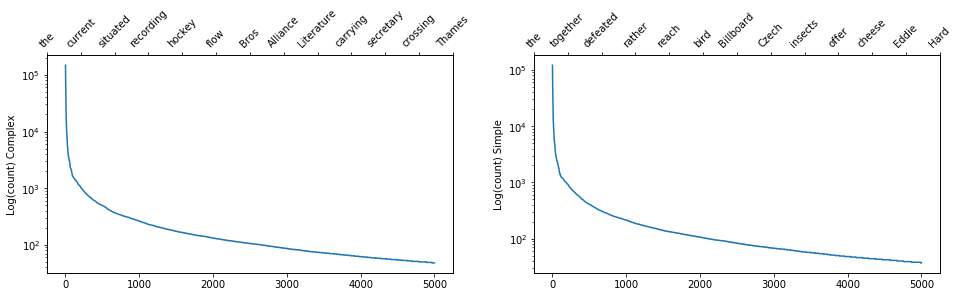

In [65]:
plt.figure(figsize=(16, 4))
N = 5000
subIndex = range(0, N, 400)

axe = plt.subplot(1,2,1)
h1 = plt.plot(range(N), np.array(complex_count_sorted[:5000]))
plt.ylabel('Log(count) Complex')
axe1 = axe.twiny()
plt.xticks(subIndex, np.array(complex_words_sorted)[subIndex], rotation = 45)
plt.yscale('log')
axe = plt.subplot(1,2,2)
h2 = plt.plot(simple_count_sorted[:5000])
plt.ylabel('Log(count) Simple')
axe1 = axe.twiny()
plt.xticks(subIndex, np.array(simple_words_sorted)[subIndex], rotation = 45)
plt.yscale('log')